## Transformers from Scratch
Work done by Jong Hoon (Sam) Park [Github](https://github.com/sjhpark)

Source / Reference: 
- https://towardsdatascience.com/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb
- https://medium.com/the-dl/transformers-from-scratch-in-pytorch-8777e346ca51#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6IjJkOWE1ZWY1YjEyNjIzYzkxNjcxYTcwOTNjYjMyMzMzM2NkMDdkMDkiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJuYmYiOjE2ODUxNDA3ODMsImF1ZCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsInN1YiI6IjExMzA3MDA1MDg0MDQzNTQ0NDU2OCIsImVtYWlsIjoic2FtcGFyay5qaEBnbWFpbC5jb20iLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwiYXpwIjoiMjE2Mjk2MDM1ODM0LWsxazZxZTA2MHMydHAyYTJqYW00bGpkY21zMDBzdHRnLmFwcHMuZ29vZ2xldXNlcmNvbnRlbnQuY29tIiwibmFtZSI6IlNhbXVlbCBQYXJrIiwicGljdHVyZSI6Imh0dHBzOi8vbGgzLmdvb2dsZXVzZXJjb250ZW50LmNvbS9hL0FBY0hUdGNCeWRYWTgtQTI4aHJSWGw1TTdPUndzQVMwVlVUWjdTMVljcHd4PXM5Ni1jIiwiZ2l2ZW5fbmFtZSI6IlNhbXVlbCIsImZhbWlseV9uYW1lIjoiUGFyayIsImlhdCI6MTY4NTE0MTA4MywiZXhwIjoxNjg1MTQ0NjgzLCJqdGkiOiJmMjk0NWM4YzMxYWFhZTNjMTFiNGE2NGE1MjdkY2M1MzNjNDU3YWU1In0.nseQAw-nO24ddvplJJyYu0t1s-W8w6c4h1wm-Ydd9PCLwieS-j5ff-9s6wDFPlmEBLiwLAbZ_ortF3_1GL97ZnV3gwG28Qutd4jDvnGK2plfJYhjNu7O7zL2oCzZvgTBePn6TbSSbm6mY52Nq7_2rGEr-zgAEHvv-OKWywzlycrBQ5E9CgcIqqLaV5YRNXYR_bLUxJwEXUIYhjI48W_u-Gapi3PszJALLIkiR9EdxKKYitcgMM66QGcvQn4T7lv_esV-4xRzyyZs-rSvfwWXyW3f7gVfWFXRMaB6VX3wtmZlBcY11iRK7Qiq4SQhkGOUoEjanTZXh1D52K8DcL2pPA
- "Attention is All You Need" paper: https://arxiv.org/abs/1706.03762

In [1]:
# import libraries
import numpy as np
import math
import copy
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

c:\Users\whdqk\anaconda3\envs\sam\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **<Scaled Dot-Product Attention & Multi-Head Attention>**
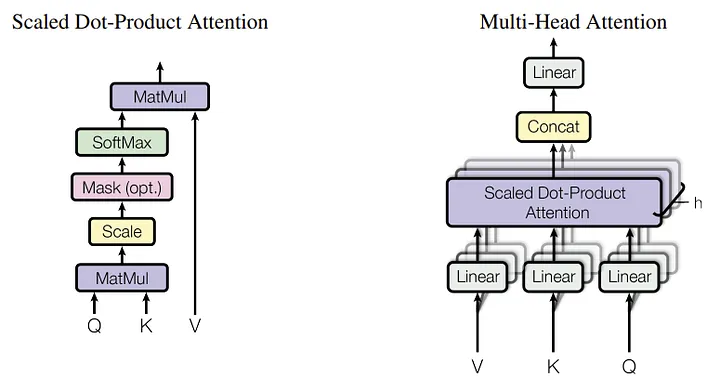

## Scaled Dot-Product Attention
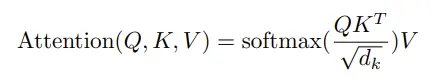
- h: number of heads (number of attention mechanisms)
- Q: Query
- K: Key
- V: Value
- Q * K.T: tells how important each word in the sentence is.

## Multi-Head Attention
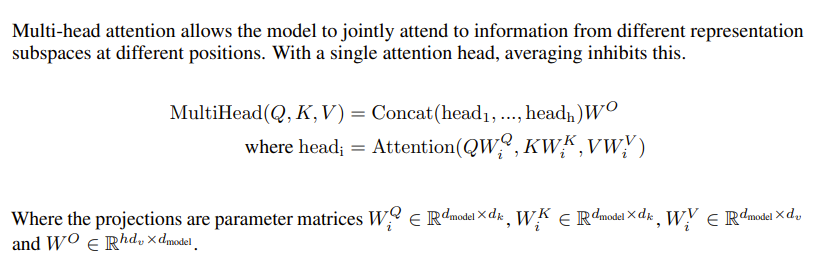

### Multi Head Attention

In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim_model, num_heads): # inputs: (dimension of model, number of heads)
        super(MultiHeadAttention, self).__init__()
        assert dim_model % num_heads == 0, "dimension of model should be divisible by number of heads."

        self.dim_model = dim_model # dimension of model
        self.num_heads = num_heads # number of heads

        self.dim_k = dim_model // num_heads # dimension of key
                                            # Note: dim_model = num_heads * dim_k

        # linear transformation layers for Query, Key, and Value
        self.W_q = nn.Linear(dim_model, dim_model) # linear transformation for Query
        self.W_k = nn.Linear(dim_model, dim_model) # linear transformation for Key
        self.W_v = nn.Linear(dim_model, dim_model) # linear transformation for Value
        
        self.W_concat = nn.Linear(dim_model, dim_model) # linear transformation for concatenated outputs

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Q: Query -- (batch_size, num_heads, seq_len, dim_model)
        # K: Key -- (batch_size, num_heads, seq_len, dim_model)
        # V: Value -- (batch_size, num_heads, seq_len, dim_model)
        # scores: attention scores -- (batch_size, num_heads, seq_len, seq_len)

        # 1. dot product Query with Key^T to compute similarity
        scores = Q @ K.transpose(-2, -1) # attention scores
        scores = scores / np.sqrt(self.dim_k) # scaled attention scores for avoiding vanishing gradients
        
        # 2. apply mask (optional)
        if mask is not None:
            scores = scores.masked_fill(mask==0, -1e9)
        
        # 3. apply softmax to obtain attention probabilities --> attention scores will be ranged in [0, 1]
        probs = nn.Softmax(dim=-1)(scores) # attention probabilities (batch_size, num_heads, seq_len, seq_len)

        # 4. multiply attention scores with Value
        output = probs @ V # (batch_size, num_heads, seq_len, dim_model)
        return output
    
    def split_heads(self, x):
        """
        Split x (torch.Tensor) by number of heads
            input: x (torch.Tensor) -- (batch_size, seq_length, dim_model)
                Note: dim_model = num_heads * dim_k
            return: x (torch.Tensor) -- (batch_size, num_heads, seq_length, dim_k)
        """
        batch_size, seq_length, dim_model = x.size()
        x = x.view(batch_size, seq_length, self.num_heads, self.dim_k) # (batch_size, seq_length, num_heads, dim_k)
        x = x.transpose(1,2) # (batch_size, num_heads, seq_length, dim_k)
        return x

    def concat_heads(self, x):
        """
        Concatenate heads of x (torch.Tensor)
        Inverse function of self.split_heads(x : torch.Tensor)
            input: x (torch.Tensor) -- (batch_size, head, length, dim_k)
            return: x (torch.Tensor) -- (batch_size, length, dim_model)
        """
        batch_size, num_heads, seq_length, dim_k = x.size()
        x = x.transpose(1,2) # (batch_size, seq_length, num_heads, dim_k)
        x = x.contiguous() # make a copy of tensor x
        x = x.view(batch_size, seq_length, self.dim_model) # (batch_size, seq_length, dim_model)
                                                           # Remember: dim_model = num_heads * dim_k
        return x
    
    def forward(self, Q, K, V, mask=None):
        '''
        return: multi-head self-attention output
                (allows the model to focus on different aspects of the input sequence)
        '''
        # Q: Query -- (batch_size, seq_len, dim_model)
        # K: Key -- (batch_size, seq_len, dim_model)
        # V: Value -- (batch_size, seq_len, dim_model)

        Q = self.split_heads(self.W_q(Q)) # (batch_size, num_heads, seq_len, dim_k)
        K = self.split_heads(self.W_k(K)) # (batch_size, num_heads, seq_len, dim_k)
        V = self.split_heads(self.W_v(V)) # (batch_size, num_heads, seq_len, dim_k)

        output = self.scaled_dot_product_attention(Q, K, V, mask) # (batch_size, num_heads, seq_len, dim_k)
        output = self.W_concat(self.concat_heads(output)) # (batch_size, seq_len, dim_model)
        return output # multi-head self-attention output


### Position-wise Fully-connected Feed-forward Network

In [3]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, dim_model, dim_hidden, drop_prob=0.1):
        super(PositionWiseFeedForward, self).__init__() 

        self.fc1 = nn.Linear(dim_model, dim_hidden) # linear transformation layer
        self.fc2 = nn.Linear(dim_hidden, dim_model) # linear transformation layer
        self.relu = nn.ReLU() # activation function
        self.dropout = nn.Dropout(p=drop_prob)
    
    def forward(self, x):
        '''
        Applies linear transformations and activation function sequentially to compute the output
        (allows the model to consider the position of elements in the sequence while making predictions).
        '''
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


### Positional Encoding
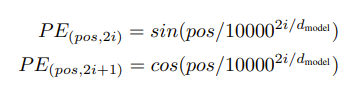

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        # initialize encoding matrix as zero matrix
        positional_encoding = torch.zeros(max_seq_length, dim_model)
        positional_encoding.requires_grad = False  # we don't need to compute gradient

        # position
        position = torch.arange(0, max_seq_length) # [0,1,2,3,4,...,max_seq_length-1]
        position = position.float().unsqueeze(dim=1) # 1D => 2D (unsqueeze to represent token's position)

        # divider
        indices = torch.arange(0, dim_model, step=2).float() # [0,2,4,6,...,dim_model-2]
        scaling_factor = -math.log(10000.0)/dim_model
        divider = torch.exp(indices * scaling_factor) 

        # compute positional encoding to inject position information of each token in the input sequence.
        positional_encoding[:, 0::2] = torch.sin(position * divider)
        positional_encoding[:, 1::2] = torch.cos(position * divider)
        
        self.register_buffer('positional_encoding', positional_encoding.unsqueeze(0))

    def forward(self, x):
        return x + self.positional_encoding[:, :x.size(1)] # Note: x.size(1) = input sequence length
    

### Layer Normalization

In [5]:
class LayerNorm(nn.Module):
    def __init__(self, dim_model, eps=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(dim_model))
        self.beta = nn.Parameter(torch.zeros(dim_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, unbiased=False, keepdim=True)
        # '-1' means last dimension. 

        out = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out + self.beta
        return out


### Encoder
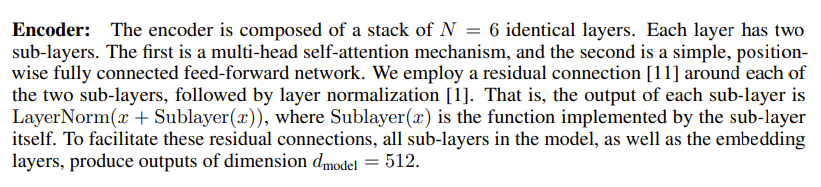
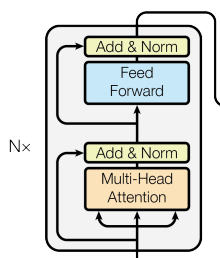

In [6]:
class Encoder(nn.Module):
    def __init__(self, dim_model, num_heads, dim_hidden, drop_prob):
        super(Encoder, self).__init__()

        # sublayer1: multi-head self-attention
        self.self_attention = MultiHeadAttention(dim_model, num_heads)
        # sublayer2: position-wise feed forward
        self.feed_forward = PositionWiseFeedForward(dim_model, dim_hidden, drop_prob)
        
        self.norm1 = LayerNorm(dim_model) # layer normalization
        self.norm2 = LayerNorm(dim_model) # layer normalization
        self.dropout1 = nn.Dropout(p=drop_prob) # dropout
        self.dropout2 = nn.Dropout(p=drop_prob) # dropout
    
    def forward(self, x, source_mask):
        _x = x
        ############ Sublayer 1 ############
        # multi-head self-attention
        x = self.self_attention(Q=x, K=x, V=x, mask=source_mask) # multi-head self-attention output
        x = self.dropout1(x)
        ############ ADD & NORM ############
        # residual connection
        x = _x + x
        # layer normalization
        x = self.norm1(x)
        ####################################

        _x = x
        ############ Sublayer 2 ############
        # position-wise feed forward
        x = self.feed_forward(x)
        x = self.dropout2(x)
        ############ ADD & NORM ############
        # residual connection
        x = _x + x
        # layer normalization
        x = self.norm2(x)
        ####################################

        return x


### Decoder
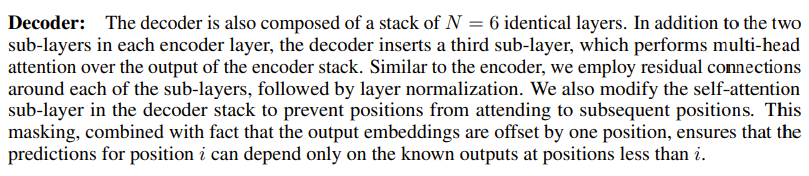
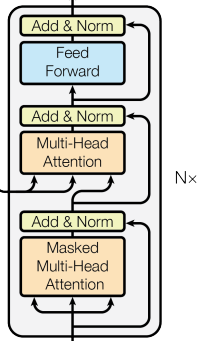

In [7]:
class Decoder(nn.Module):
    def __init__(self, dim_model, num_heads, dim_hidden, drop_prob):
        super(Decoder, self).__init__()
        
        # sublayer1: masked multi-head self-attention
        self.self_attention = MultiHeadAttention(dim_model, num_heads)
        # sublayer2: cross multi-head attention
        self.cross_attention = MultiHeadAttention(dim_model, num_heads)
        # sublayer3: position-wise feed forward
        self.feed_forward = PositionWiseFeedForward(dim_model, dim_hidden, drop_prob)
        
        self.norm1 = LayerNorm(dim_model) # layer normalization
        self.norm2 = LayerNorm(dim_model) # layer normalization
        self.norm3 = LayerNorm(dim_model) # layer normalization
        self.dropout1 = nn.Dropout(p=drop_prob) # dropout
        self.dropout2 = nn.Dropout(p=drop_prob) # dropout
        self.dropout3 = nn.Dropout(p=drop_prob) # dropout
    
    def forward(self, x, encoder_output, source_mask, target_mask):
        _x = x
        ############ Sublayer 1 ############
        # multi-head self-attention
        x = self.self_attention(Q=x, K=x, V=x, mask=target_mask) # multi-head self-attention output
        x = self.dropout1(x)
        ############ ADD & NORM ############
        # residual connection
        x = _x + x
        # layer normalization
        x = self.norm1(x)
        ####################################

        _x = x
        ############ Sublayer 2 ############
        # cross-attention
        x = self.cross_attention(Q=x, K=encoder_output, V=encoder_output, mask=source_mask) # cross multi-head self-attention output
        x = self.dropout2(x)
        ############ ADD & NORM ############
        # residual connection
        x = _x + x
        # layer normalization
        x = self.norm2(x)
        ####################################

        _x = x
        ############ Sublayer 3 ############
        # position-wise feed forward
        x = self.feed_forward(x)
        x = self.dropout3(x)
        ############ ADD & NORM ############
        # residual connection
        x = _x + x
        # layer normalization
        x = self.norm3(x)
        ####################################

        return x


### Transformer Model
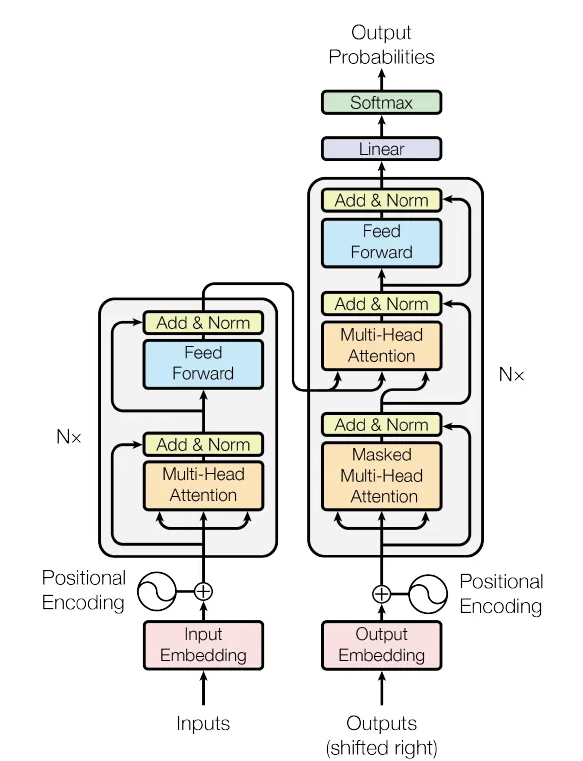

In [8]:
class Transformer(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, 
                 dim_model, num_heads, num_layers, dim_hidden, max_seq_length, drop_prob):
        super(Transformer, self).__init__()

        self.encoder_embedding = nn.Embedding(num_embeddings=source_vocab_size, embedding_dim=dim_model)
        self.decoder_embedding = nn.Embedding(num_embeddings=target_vocab_size, embedding_dim=dim_model)
        self.positional_encoding = PositionalEncoding(dim_model, max_seq_length)

        self.encoder = nn.ModuleList([Encoder(dim_model, num_heads, dim_hidden, drop_prob) 
                                      for layer in range(num_layers)])
        self.decoder = nn.ModuleList([Decoder(dim_model, num_heads, dim_hidden, drop_prob)
                                      for layer in range(num_layers)])
        
        self.fc = nn.Linear(dim_model, target_vocab_size)
        self.dropout = nn.Dropout(p=drop_prob)
    
    def mask_generation(self, source, target):
        '''
        Generates binary (boolean) masks for source and target sequences.
            Ignores padding tokens
            Prevents the decoder from attending to future tokens.
        '''
        source_mask = (source != 0).unsqueeze(1).unsqueeze(2) # (batch_size, 1, 1, source_seq_length)
        
        target_mask = (target != 0).unsqueeze(1).unsqueeze(3) # (batch_size, 1, target_seq_length, 1)
        seq_length = target.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        target_mask = target_mask & nopeak_mask
        
        return source_mask, target_mask

    def forward(self, source, target):
        # generate source and target masks
        source_mask, target_mask = self.mask_generation(source, target)

        # compute source and target embeddings
        source_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(source)))
        target_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(target)))

        # process the source embeddings through the encoder
        # update encoder output
        encoder_output = source_embedded
        for encoder_layer in self.encoder:
            encoder_output = encoder_layer(encoder_output, source_mask)

        # process the target embeddings through the decoder
        # update decoder output
        decoder_output = target_embedded
        for decoder_layer in self.decoder:
            decoder_output = decoder_layer(decoder_output, encoder_output, source_mask, target_mask)
        
        # apply linear layer to decoder output
        output = self.fc(decoder_output)
        return output


In [9]:
# hyperparameters
source_vocab_size = 5000
target_vocab_size = 5000
dim_model = 512
num_heads = 8
num_layers = 6
dim_hidden = 2048
max_seq_length = 100
drop_prob = 0.1
epochs = 100
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model
transformer = Transformer(source_vocab_size, target_vocab_size, dim_model, num_heads, 
                          num_layers, dim_hidden, max_seq_length, drop_prob)

# generate random sample data
src_data = torch.randint(1, source_vocab_size, (64, max_seq_length)) # (batch_size, seq_length)
tgt_data = torch.randint(1, target_vocab_size, (64, max_seq_length)) # (batch_size, seq_length)

# loss function
criterion = nn.CrossEntropyLoss(ignore_index=0)

# optimizer
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# Training
transformer.train()
for epoch in tqdm(range(epochs), desc="Epoch"):
    # Zero out the gradients
    optimizer.zero_grad()
    # Predictions from forward pass
    output = transformer(src_data, tgt_data[:, :-1])
    # Compute the loss
    loss = criterion(output.contiguous().view(-1, target_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    # Backpropagation
    loss.backward()
    # Update the parameters
    optimizer.step()
    # Display progress
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")


Epoch:   1%|          | 1/100 [00:20<34:28, 20.90s/it]

Epoch: 1, Loss: 8.678241729736328


Epoch:   2%|▏         | 2/100 [00:48<40:06, 24.56s/it]

Epoch: 2, Loss: 8.557222366333008


Epoch:   3%|▎         | 3/100 [01:12<39:47, 24.61s/it]

Epoch: 3, Loss: 8.489975929260254


Epoch:   4%|▍         | 4/100 [01:37<39:35, 24.74s/it]

Epoch: 4, Loss: 8.434635162353516


Epoch:   5%|▌         | 5/100 [02:00<38:18, 24.19s/it]

Epoch: 5, Loss: 8.38732624053955


Epoch:   6%|▌         | 6/100 [02:25<38:18, 24.46s/it]

Epoch: 6, Loss: 8.32436752319336


Epoch:   7%|▋         | 7/100 [02:50<38:13, 24.66s/it]

Epoch: 7, Loss: 8.24676513671875


Epoch:   8%|▊         | 8/100 [03:17<38:32, 25.13s/it]

Epoch: 8, Loss: 8.174428939819336


Epoch:   9%|▉         | 9/100 [03:43<38:38, 25.48s/it]

Epoch: 9, Loss: 8.092662811279297


Epoch:  10%|█         | 10/100 [04:09<38:20, 25.56s/it]

Epoch: 10, Loss: 8.016606330871582


Epoch:  11%|█         | 11/100 [04:35<38:12, 25.76s/it]

Epoch: 11, Loss: 7.944058895111084


Epoch:  12%|█▏        | 12/100 [05:01<37:59, 25.91s/it]

Epoch: 12, Loss: 7.866349697113037


Epoch:  13%|█▎        | 13/100 [05:27<37:30, 25.87s/it]

Epoch: 13, Loss: 7.794336795806885


Epoch:  14%|█▍        | 14/100 [05:52<36:54, 25.75s/it]

Epoch: 14, Loss: 7.7119669914245605


Epoch:  15%|█▌        | 15/100 [06:18<36:28, 25.75s/it]

Epoch: 15, Loss: 7.627843379974365


Epoch:  16%|█▌        | 16/100 [06:44<36:06, 25.79s/it]

Epoch: 16, Loss: 7.557147979736328


Epoch:  17%|█▋        | 17/100 [07:10<35:45, 25.85s/it]

Epoch: 17, Loss: 7.475982189178467


Epoch:  18%|█▊        | 18/100 [07:36<35:18, 25.84s/it]

Epoch: 18, Loss: 7.396733283996582


Epoch:  19%|█▉        | 19/100 [08:02<34:56, 25.88s/it]

Epoch: 19, Loss: 7.3162946701049805


Epoch:  20%|██        | 20/100 [08:31<35:56, 26.95s/it]

Epoch: 20, Loss: 7.245659828186035


Epoch:  21%|██        | 21/100 [09:03<37:16, 28.31s/it]

Epoch: 21, Loss: 7.1644606590271


Epoch:  22%|██▏       | 22/100 [09:38<39:30, 30.39s/it]

Epoch: 22, Loss: 7.09310245513916


Epoch:  23%|██▎       | 23/100 [10:07<38:29, 29.99s/it]

Epoch: 23, Loss: 7.015764236450195


Epoch:  24%|██▍       | 24/100 [10:37<37:52, 29.90s/it]

Epoch: 24, Loss: 6.947393894195557


Epoch:  25%|██▌       | 25/100 [11:04<36:23, 29.11s/it]

Epoch: 25, Loss: 6.868347644805908


Epoch:  26%|██▌       | 26/100 [11:31<35:03, 28.43s/it]

Epoch: 26, Loss: 6.797918796539307


Epoch:  27%|██▋       | 27/100 [12:00<35:05, 28.84s/it]

Epoch: 27, Loss: 6.734196186065674


Epoch:  28%|██▊       | 28/100 [12:29<34:39, 28.88s/it]

Epoch: 28, Loss: 6.6742377281188965


Epoch:  29%|██▉       | 29/100 [12:57<33:33, 28.35s/it]

Epoch: 29, Loss: 6.5914788246154785


Epoch:  30%|███       | 30/100 [13:22<31:58, 27.40s/it]

Epoch: 30, Loss: 6.51666259765625


Epoch:  31%|███       | 31/100 [13:44<29:42, 25.83s/it]

Epoch: 31, Loss: 6.44426155090332


Epoch:  32%|███▏      | 32/100 [14:06<28:00, 24.72s/it]

Epoch: 32, Loss: 6.387882232666016


Epoch:  33%|███▎      | 33/100 [14:28<26:43, 23.93s/it]

Epoch: 33, Loss: 6.321446895599365


Epoch:  34%|███▍      | 34/100 [14:50<25:41, 23.36s/it]

Epoch: 34, Loss: 6.2585625648498535


Epoch:  35%|███▌      | 35/100 [15:15<25:43, 23.75s/it]

Epoch: 35, Loss: 6.193867206573486


Epoch:  36%|███▌      | 36/100 [15:39<25:32, 23.94s/it]

Epoch: 36, Loss: 6.134426116943359


Epoch:  37%|███▋      | 37/100 [16:04<25:30, 24.29s/it]

Epoch: 37, Loss: 6.068785190582275


Epoch:  38%|███▊      | 38/100 [16:37<27:37, 26.73s/it]

Epoch: 38, Loss: 6.013120651245117


Epoch:  39%|███▉      | 39/100 [17:03<27:10, 26.73s/it]

Epoch: 39, Loss: 5.945242404937744


Epoch:  40%|████      | 40/100 [17:31<27:06, 27.11s/it]

Epoch: 40, Loss: 5.885316371917725


Epoch:  41%|████      | 41/100 [17:58<26:36, 27.06s/it]

Epoch: 41, Loss: 5.826540946960449


Epoch:  42%|████▏     | 42/100 [18:26<26:14, 27.15s/it]

Epoch: 42, Loss: 5.7682414054870605


Epoch:  43%|████▎     | 43/100 [18:55<26:24, 27.80s/it]

Epoch: 43, Loss: 5.70529842376709


Epoch:  44%|████▍     | 44/100 [19:22<25:39, 27.49s/it]

Epoch: 44, Loss: 5.65745210647583


Epoch:  45%|████▌     | 45/100 [19:48<24:47, 27.05s/it]

Epoch: 45, Loss: 5.597227573394775


Epoch:  46%|████▌     | 46/100 [20:14<23:58, 26.63s/it]

Epoch: 46, Loss: 5.532289505004883


Epoch:  47%|████▋     | 47/100 [20:39<23:17, 26.36s/it]

Epoch: 47, Loss: 5.480937480926514


Epoch:  48%|████▊     | 48/100 [21:05<22:35, 26.06s/it]

Epoch: 48, Loss: 5.42531681060791


Epoch:  49%|████▉     | 49/100 [21:29<21:42, 25.54s/it]

Epoch: 49, Loss: 5.369135856628418


Epoch:  50%|█████     | 50/100 [21:51<20:24, 24.49s/it]

Epoch: 50, Loss: 5.3133721351623535


Epoch:  51%|█████     | 51/100 [22:13<19:24, 23.76s/it]

Epoch: 51, Loss: 5.257282257080078


Epoch:  52%|█████▏    | 52/100 [22:35<18:37, 23.29s/it]

Epoch: 52, Loss: 5.202842712402344


Epoch:  53%|█████▎    | 53/100 [22:57<17:50, 22.78s/it]

Epoch: 53, Loss: 5.155393600463867


Epoch:  54%|█████▍    | 54/100 [23:21<17:42, 23.11s/it]

Epoch: 54, Loss: 5.098104000091553


Epoch:  55%|█████▌    | 55/100 [23:45<17:31, 23.37s/it]

Epoch: 55, Loss: 5.046403884887695


Epoch:  56%|█████▌    | 56/100 [24:07<16:52, 23.00s/it]

Epoch: 56, Loss: 4.988687038421631


Epoch:  57%|█████▋    | 57/100 [24:28<16:03, 22.41s/it]

Epoch: 57, Loss: 4.942097187042236


Epoch:  58%|█████▊    | 58/100 [24:50<15:39, 22.37s/it]

Epoch: 58, Loss: 4.887790679931641


Epoch:  59%|█████▉    | 59/100 [25:14<15:30, 22.69s/it]

Epoch: 59, Loss: 4.832756519317627


Epoch:  60%|██████    | 60/100 [25:36<15:10, 22.76s/it]

Epoch: 60, Loss: 4.790126800537109


Epoch:  61%|██████    | 61/100 [25:59<14:43, 22.66s/it]

Epoch: 61, Loss: 4.744205951690674


Epoch:  62%|██████▏   | 62/100 [26:21<14:14, 22.49s/it]

Epoch: 62, Loss: 4.696842670440674


Epoch:  63%|██████▎   | 63/100 [26:44<13:55, 22.59s/it]

Epoch: 63, Loss: 4.639599800109863


Epoch:  64%|██████▍   | 64/100 [27:07<13:43, 22.87s/it]

Epoch: 64, Loss: 4.589122295379639


Epoch:  65%|██████▌   | 65/100 [27:29<13:11, 22.62s/it]

Epoch: 65, Loss: 4.53757381439209


Epoch:  66%|██████▌   | 66/100 [27:53<12:58, 22.89s/it]

Epoch: 66, Loss: 4.493478298187256


Epoch:  67%|██████▋   | 67/100 [28:17<12:49, 23.31s/it]

Epoch: 67, Loss: 4.4423041343688965


Epoch:  68%|██████▊   | 68/100 [28:41<12:32, 23.51s/it]

Epoch: 68, Loss: 4.3927903175354


Epoch:  69%|██████▉   | 69/100 [29:02<11:48, 22.84s/it]

Epoch: 69, Loss: 4.345724582672119


Epoch:  70%|███████   | 70/100 [29:21<10:48, 21.63s/it]

Epoch: 70, Loss: 4.303285121917725


Epoch:  71%|███████   | 71/100 [29:42<10:22, 21.45s/it]

Epoch: 71, Loss: 4.253251075744629


Epoch:  72%|███████▏  | 72/100 [30:07<10:29, 22.50s/it]

Epoch: 72, Loss: 4.204089641571045


Epoch:  73%|███████▎  | 73/100 [30:33<10:30, 23.35s/it]

Epoch: 73, Loss: 4.155228137969971


Epoch:  74%|███████▍  | 74/100 [30:57<10:18, 23.80s/it]

Epoch: 74, Loss: 4.108109474182129


Epoch:  75%|███████▌  | 75/100 [31:22<10:02, 24.09s/it]

Epoch: 75, Loss: 4.062133312225342


Epoch:  76%|███████▌  | 76/100 [31:47<09:44, 24.36s/it]

Epoch: 76, Loss: 4.014031887054443


Epoch:  77%|███████▋  | 77/100 [32:12<09:25, 24.59s/it]

Epoch: 77, Loss: 3.9732189178466797


Epoch:  78%|███████▊  | 78/100 [32:38<09:05, 24.79s/it]

Epoch: 78, Loss: 3.918795108795166


Epoch:  79%|███████▉  | 79/100 [33:03<08:43, 24.93s/it]

Epoch: 79, Loss: 3.877840995788574


Epoch:  80%|████████  | 80/100 [33:28<08:22, 25.14s/it]

Epoch: 80, Loss: 3.8319289684295654


Epoch:  81%|████████  | 81/100 [33:54<07:58, 25.17s/it]

Epoch: 81, Loss: 3.7937748432159424


Epoch:  82%|████████▏ | 82/100 [34:18<07:30, 25.03s/it]

Epoch: 82, Loss: 3.7424609661102295


Epoch:  83%|████████▎ | 83/100 [34:43<07:03, 24.93s/it]

Epoch: 83, Loss: 3.7026915550231934


Epoch:  83%|████████▎ | 83/100 [35:12<07:12, 25.45s/it]


KeyboardInterrupt: 